In [1]:
!pip install nilearn 

     |████████████████████████████████| 10.1 MB 4.8 MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets ,models , transforms
import json
from torch.utils.data import Dataset, DataLoader ,random_split
from PIL import Image
from pathlib import Path

import nibabel as nb
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
classLabels = [
               "liver", 
               "kidney-r", 
               "kidney-l", 
               "femur-r", 
               "femur-l", 
               "bladder",
               "heart",
               "lung-r",
               "lung-l",
               "spleen",
               "pancreas",
               ]
print(torch.__version__)

1.10.0+cu111


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Prepare data

In [5]:
df = pd.read_csv(
    "/content/drive/MyDrive/LITS_all_train/train_multilabel.csv", 

    )

# train_df = df[df.index.isin(set(range(2, 11)))]
# test_df = df[df.index.isin(set(range(20, 24)))]




## Model Definition

In [6]:
transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((256,256)), 
                                transforms.ToTensor(),
                                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                               ])

In [7]:
model = models.resnet18(pretrained=False) 
num_features = model.fc.in_features 
# print(num_features)

# for param in model.parameters():
#   param.requires_grad_(False)

512


In [8]:
def create_head(num_features , number_classes ,dropout_prob=0.5 ,activation_func =nn.ReLU):
  features_lst = [num_features , num_features//2 , num_features//4]
  layers = []
  for in_f ,out_f in zip(features_lst[:-1] , features_lst[1:]):
    layers.append(nn.Linear(in_f , out_f))
    layers.append(activation_func())
    layers.append(nn.BatchNorm1d(out_f))
    if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
  layers.append(nn.Linear(features_lst[-1] , number_classes))
  return nn.Sequential(*layers)

top_head = create_head(num_features , len(classLabels)) 
model.fc = top_head 

import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005 )
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

## Model norm


## Training

In [ ]:
from tqdm import trange
from tqdm import tqdm
from sklearn.metrics import precision_score,f1_score
import copy

    # label = torch.tensor(row[1:12].tolist() , dtype=torch.float32)
    # image = np.expand_dims(image,axis=2)
    # image = np.repeat(image, 3, axis=2).T
    # image = torch.as_tensor(image, dtype=torch.float)
    # # print(image.shape)

    # if self.transforms is not None:
    #   image = self.transforms(image)


def get_batch(df, idx, idx_end):
  img_3d = nb.load(df.iloc[idx]['img_path']).get_fdata()
  batch_img = []
  batch_lbl = []
  for i in range(idx, idx_end):
    row = df.iloc[idx]
    if row['xyz'] == 'x':
      image = img_3d[row['coord'],:,:]
    if row['xyz'] == 'y':
      image = img_3d[:, row['coord'],:]
    if row['xyz'] == 'z':
      image = img_3d[:,:,row['coord']]    

    label = torch.tensor(row[1:12].tolist() , dtype=torch.float32)

    image = np.expand_dims(image,axis=2)
    image = np.repeat(image, 3, axis=2).T
    image = torch.as_tensor(image, dtype=torch.float)
    image = transform(image)
    batch_img.append(image)
    batch_lbl.append(label)
  yield  (
      torch.stack(batch_img),
      torch.stack(batch_lbl)
  )



def train(model, df, batch_size, criterion , optimizer ,scheduler, num_epochs=5):
  df = df.copy()
  df["person"] = df["person"].astype(int)
  train_df = df[df['person'].isin(set(range(0, 20)))]
  test_df = df[df['person'].isin(set(range(20, 25)))]

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in trange(num_epochs,desc="Epochs"):
    result = []
    for phase in ['train', 'val']:
      if phase=="train":     # put the model in training mode
        model.train()
        len_data_train = 0
      else:     # put the model in validation mode
        model.eval()
        len_data_test = 0

      # keep track of training and validation loss
      running_loss = 0.0
      running_corrects = 0.0  
      if phase == 'train':
        df_t = train_df.copy()
      else:
        df_t = test_df.copy()

  
      for i in range(0, df_t.shape[0], batch_size):
        if i + batch_size< df_t.shape[0]:
          if df_t.iloc[i]['person'] == df_t.iloc[i + batch_size]["person"]:
            batch = get_batch(df_t, i, i + batch_size)
            if phase == 'train':
              len_data_train += batch_size
            else:
              len_data_test += batch_size
          else:
            continue
          for data, target in batch:
          # for data, target in tqdm(dataloader[phase]):
              #load the data and target to respective device

              data, target = data.to(device)  , target.to(device)

              with torch.set_grad_enabled(phase=="train"):
                optimizer.zero_grad()

                output = model(data)
                loss = criterion(output,target)
                preds = torch.sigmoid(output).data > 0.5
                preds = preds.to(torch.float32)
                
                if phase=="train"  :
      
                  loss.backward()

                  optimizer.step()
                running_loss += loss.item() * data.size(0)
                score = f1_score(target.to("cpu").to(torch.int).numpy() ,preds.to("cpu").to(torch.int).numpy() , average="samples")  * data.size(0)
                running_corrects += score

          if phase=="train":
              scheduler.step()
              
              # print(score)
        
      if phase == 'train':
        epoch_loss = running_loss / len_data_train
        epoch_acc = running_corrects / len_data_train
      else:
        epoch_loss = running_loss / len_data_test
        epoch_acc = running_corrects / len_data_test
        if epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())
      result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      print(result)

  print(f'Best val Acc: {best_acc:4f}')
  model.load_state_dict(best_model_wts)

In [ ]:
train(model, df, 128, criterion, optimizer,exp_lr_scheduler, num_epochs=5)

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

## Saving & Loading model

In [34]:
def createCheckpoint(filename=Path("/content/resnet_epoch4_my.pt")):
  checkpoint = {
              'epoch': 6,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              "batch_size":64,
  } # save all important stuff
  torch.save(checkpoint , filename, _use_new_zipfile_serialization=False)
createCheckpoint()

In [35]:
import copy

best_model_wts = copy.deepcopy(model.state_dict())
torch.save(best_model_wts, '/content/resnet_epoch4_ira.pt')


In [38]:
model.load_state_dict(torch.load('/content/resnet_epoch4_ira.pt'))

<All keys matched successfully>

In [ ]:
# Load
'''
First Intialize the model and then just load it
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

'''

checkpoint = torch.load(Path("/content/LatestCheckpoint_epoch1_new.pt"), map_location=torch.device('cpu'))
model.load_state_dict(checkpoint) #['model_state_dict']
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# batch_size = checkpoint['batch_size']

model.eval() ## or model.train()
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.01
    lr: 0.00952254248593742
    weight_decay: 0
)

In [ ]:
test_img = df[df.index == 11]
row = test_img.iloc[150]
img_data = nb.load(row['img_path'])
img_3d = img_data.get_fdata()
if row['xyz'] == 'x':
  image = img_3d[row['coord'],:,:]
if row['xyz'] == 'y':
  image = img_3d[:, row['coord'],:]
if row['xyz'] == 'z':
  image = img_3d[:,:,row['coord']]

In [ ]:
def predict_one(image):
  image = np.expand_dims(image,axis=2)
  image = np.repeat(image, 3, axis=2).T
  image = torch.as_tensor(image, dtype=torch.float)

  image = transform(image)
  image = image.to(device)
  preds = model(image.unsqueeze(0))
  preds = (torch.sigmoid(preds).data > 0.5).type(torch.uint8) 
  return [name for pred, name in zip(preds, classLabels)]

In [ ]:
predict_one(image)

['liver']

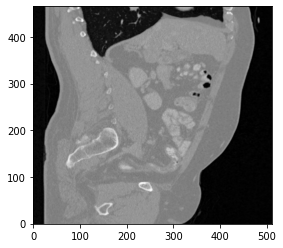

In [ ]:
plt.imshow(image.T, cmap="Greys_r", origin="lower")

In [ ]:
true_val = row[:11].values
[name for true, name in zip(true_val, classLabels) if true]

['liver', 'kidney-r']